In [1]:
using Random
using Statistics
using Distributions
using ShiftedArrays
using CategoricalArrays
# using StatsPlots
using HypothesisTests

using DataFrames
using DataFramesMeta
using SpecialFunctions
using LinearAlgebra
using StatsFuns
using MixedModels
using CodecZlib
using JLD2
using Serialization
using LaTeXStrings
using ShiftedArrays: lag

using CairoMakie  
# CairoMakie.activate!(inline=true)
CairoMakie.activate!(type = "png", inline=true, px_per_unit=2.0, pt_per_unit=1.0)

In [4]:
using RLSR
using EM
include("../code/em_scripts.jl")
include("../code/sailing_base_lrl_blockwise_twoλ.jl")

Dict{String, Function} with 8 entries:
  "log_λ2"    => #47
  "c"         => #48
  "log_λ1"    => #46
  "α"         => #41
  "initial_V" => #43
  "λ1"        => #44
  "αT"        => #42
  "λ2"        => #45

In [5]:
set_theme!()
update_theme!(
        fontsize = 7,
        fonts = (; regular= "Helvetica", bold="Helvetica Bold"),
        # figure_padding = (10.0, 10.0, 10.0, 10.0),
        figure_padding = (5.0, 5.0, 5.0, 5.0),
        Lines = (
            linewidth = 1.0,
        )
    )


# Participants

We're going to load participant data, as well as best-fit parameters for models with either one or two $\lambda$ parameters.

In [6]:
file_prefix = "blockwise"
full_df = load("../derived/$(file_prefix).jld2")["full_df"]
ntrials = maximum(full_df.trial)
full_df[1:5, :]

Row,state1,state2,state3,endState,endBranchLeft,reward,action1Left,action2Left,rewardₜ₋₁,rewardₜ₋₂,state1ₜ₋₁,state1ₜ₋₂,state1ₜ₋₃,state2ₜ₋₁,state2ₜ₋₂,state3ₜ₋₁,state3ₜ₋₂,endStateₜ₋₁,endStateₜ₋₂,endBranchLeftₜ₋₁,endBranchLeftₜ₋₂,trial,subject,action1TowardsPrevEnd,action1Persistance,endBranchₜ₋₁SameAsLastChoice,priorMoveAt1,priorMoveAt2,priorMoveAt3,parentPriorMove,parentPriorMoveToEndState,parentPriorMoveToEndStateₜ₋₁,priorRewardAt2,priorRewardAt3,priorRewardAt4,priorRewardAt5,priorRewardAt6,priorRewardAt7,endStateSiblingPriorReward,endStateSiblingPriorRewardₜ₋₁,endStatePriorReward,endStatePriorRewardₜ₋₁,endStatePriorRewardₜ₋₂,priorRewardLeftBranch,priorRewardRightBranch,endStateBranchPriorReward,endStateBranchPriorRewardₜ₋₁,endStateBranchPriorRewardₜ₋₂,sub,assignment,r1,r2,r3,r4,rt_boat,rt_island,rewscaled,rwd_swap,rwd_swap_type,block_ind,block_num
,Int64,Int64,Int64,Int64,Bool,Float64,Bool?,Bool?,Float64?,Float64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Int64,String,Bool?,Bool?,Bool?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,String,Float64,Float64,Float64,Float64,Real,Union…,Float64,Bool,String,Int64,Int64
1,1,3,6,6,false,0.0,false,true,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,001,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,31.6,1743.3,-1.0,false,start,0,0
2,4,-1,-1,4,true,1.0,missing,missing,0.0,missing,1,missing,missing,3,missing,6,missing,6,missing,false,missing,2,001,missing,missing,missing,3,missing,6,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,3324.2,,1.0,false,start,1,0
3,1,2,4,4,true,1.0,true,true,1.0,0.0,4,1,missing,missing,3,missing,6,4,6,true,false,3,001,true,false,false,3,missing,6,missing,missing,missing,missing,missing,1.0,missing,0.0,missing,missing,missing,1.0,missing,missing,1.0,0.0,1.0,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,1050.3,967,1.0,false,start,2,0
4,7,-1,-1,7,false,1.0,missing,missing,1.0,1.0,1,4,1,2,missing,4,missing,4,4,true,true,4,001,missing,missing,true,2,4,6,6,false,missing,missing,missing,1.0,missing,0.0,missing,0.0,missing,missing,1.0,missing,1.0,0.0,0.0,1.0,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,2148.6,,1.0,false,start,3,0
5,1,2,4,4,true,1.0,true,true,1.0,1.0,7,1,4,missing,2,missing,4,7,4,false,true,5,001,false,true,false,2,4,6,4,true,false,missing,missing,1.0,missing,0.0,1.0,missing,0.0,1.0,missing,1.0,1.0,1.0,1.0,0.0,1.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,841.6,1189.4,1.0,false,start,4,0


In [8]:
s = "blockwise"
ver = "lrlblockwise_twoλ_BLRL_BBoat_λ1_aT_islandbias_boatbias_rewscaled_initx"
r1 = load("../results/$(s)/$(s)_$(ver).jld2")["$(s)_$(ver)"]
HTML(show_results(r1))

HTML{String}("<pre>[\"βLRL\", \"βBoat\", \"island_stay_bias\", \"boat_stay_bias\", \"α\", \"αT\", \"log_λ1\"]<br/></pre>β:<br/><pre> βLRL  βBoat islan boat_ α      αT     log_λ1 <br/> 1.98  2.0  0.67  0.43  <span style='color: red'>-0.19</span>  <span style='color: red'>-0.53</span>  <span style='color: red'>-0.48</span><br/>p:<br/> 0.01  0.01  0.01  0.01  0.05  0.01  0.01</pre>σ²:<br/><pre>7×7 Diagonal{Float64, Vector{Float64}}:<br/> 1.59   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅    1.06   ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅    0.78   ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅    0.31   ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅    0.79   ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅    0.93   ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.95</pre>")

In [9]:
s = "blockwise"
ver = "lrlblockwise_twoλ_BLRL_BBoat_λ1_λ2_aT_islandbias_boatbias_rewscaled_initx"
r2 = load("../results/$(s)/$(s)_$(ver).jld2")["$(s)_$(ver)"]
HTML(show_results(r2))

HTML{String}("<pre>[\"βLRL\", \"βBoat\", \"island_stay_bias\", \"boat_stay_bias\", \"α\", \"αT\", \"log_λ1\", \"log_λ2\"]<br/></pre>β:<br/><pre> βLRL  βBoat islan boat_ α      αT     log_λ1 log_λ2 <br/> 1.99  1.98  0.67  0.44  <span style='color: red'>-0.17</span>  <span style='color: red'>-0.5</span>  <span style='color: red'>-0.38</span>  <span style='color: red'>-1.37</span><br/>p:<br/> 0.01  0.01  0.01  0.01  0.07  0.01  0.03  0.01</pre>σ²:<br/><pre>8×8 Diagonal{Float64, Vector{Float64}}:<br/> 1.65   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅    1.07   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅    0.79   ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅    0.31   ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅    0.76   ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅    0.99   ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.89   ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    1.46</pre>")

Preprocessing 
We'll do a little bit of preprocessing, primarily just removing trials with missing data, as well as creating centered variables (centering is being done at the group level)

In [10]:
df_reg_participants = copy(full_df)

df_reg_participants = @chain df_reg_participants begin
    @subset(:trial .> 1) # Ignore the first trial (no previous state info)
    @subset(:state1ₜ₋₁ .> 3) # End states
    dropmissing(:action1TowardsPrevEnd)
    dropmissing(:parentPriorMoveToEndStateₜ₋₁)
    dropmissing(:endStateSiblingPriorRewardₜ₋₁)
    dropmissing(:endBranchₜ₋₁SameAsLastChoice)
    dropmissing(:rewardₜ₋₁)
    @transform(:endStateSiblingPriorNoRewardₜ₋₁ = :endStateSiblingPriorRewardₜ₋₁ .== 0)
end

df_reg_participants = @chain df_reg_participants begin
    # groupby(:subject)
    @transform(:c_rewardₜ₋₁ = :rewardₜ₋₁ .- mean(:rewardₜ₋₁))
    @transform(:c_parentPriorMoveToEndStateₜ₋₁ = :parentPriorMoveToEndStateₜ₋₁ .- mean(:parentPriorMoveToEndStateₜ₋₁))
    @transform(:c_endStateSiblingPriorNoRewardₜ₋₁ = :endStateSiblingPriorNoRewardₜ₋₁ .- mean(:endStateSiblingPriorNoRewardₜ₋₁))
end

df_reg_participants.rewardₜ₋₁ .= df_reg_participants.rewardₜ₋₁ .== 1
df_reg_participants.endStateSiblingPriorRewardₜ₋₁ .= df_reg_participants.endStateSiblingPriorRewardₜ₋₁ .== 1

df_reg_participants[1:5, :]

Row,state1,state2,state3,endState,endBranchLeft,reward,action1Left,action2Left,rewardₜ₋₁,rewardₜ₋₂,state1ₜ₋₁,state1ₜ₋₂,state1ₜ₋₃,state2ₜ₋₁,state2ₜ₋₂,state3ₜ₋₁,state3ₜ₋₂,endStateₜ₋₁,endStateₜ₋₂,endBranchLeftₜ₋₁,endBranchLeftₜ₋₂,trial,subject,action1TowardsPrevEnd,action1Persistance,endBranchₜ₋₁SameAsLastChoice,priorMoveAt1,priorMoveAt2,priorMoveAt3,parentPriorMove,parentPriorMoveToEndState,parentPriorMoveToEndStateₜ₋₁,priorRewardAt2,priorRewardAt3,priorRewardAt4,priorRewardAt5,priorRewardAt6,priorRewardAt7,endStateSiblingPriorReward,endStateSiblingPriorRewardₜ₋₁,endStatePriorReward,endStatePriorRewardₜ₋₁,endStatePriorRewardₜ₋₂,priorRewardLeftBranch,priorRewardRightBranch,endStateBranchPriorReward,endStateBranchPriorRewardₜ₋₁,endStateBranchPriorRewardₜ₋₂,sub,assignment,r1,r2,r3,r4,rt_boat,rt_island,rewscaled,rwd_swap,rwd_swap_type,block_ind,block_num,endStateSiblingPriorNoRewardₜ₋₁,c_rewardₜ₋₁,c_parentPriorMoveToEndStateₜ₋₁,c_endStateSiblingPriorNoRewardₜ₋₁
,Int64,Int64,Int64,Int64,Bool,Float64,Bool?,Bool?,Bool,Float64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Int64,String,Bool,Bool?,Bool,Int64?,Int64?,Int64?,Int64?,Bool?,Bool,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Bool,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,String,Float64,Float64,Float64,Float64,Real,Union…,Float64,Bool,String,Int64,Int64,Bool,Float64,Float64,Float64
1,1,2,4,4,true,1.0,true,true,true,1.0,7,1,4,missing,2,missing,4,7,4,false,true,5,001,false,true,false,2,4,6,4,true,false,missing,missing,1.0,missing,0.0,1.0,missing,false,1.0,missing,1.0,1.0,1.0,1.0,0.0,1.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,841.6,1189.4,1.0,false,start,4,0,true,0.494101,-0.497727,0.414883
2,1,2,4,4,true,0.0,true,true,false,1.0,5,1,7,missing,2,missing,4,5,4,true,true,7,001,true,true,true,2,4,6,4,true,false,missing,missing,1.0,0.0,0.0,1.0,0.0,true,1.0,missing,1.0,0.0,1.0,0.0,1.0,1.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,733.3,882.9,-1.0,false,start,6,0,false,-0.505899,-0.497727,-0.585117
3,1,2,4,4,true,0.0,true,true,false,0.0,6,1,5,missing,2,missing,4,6,4,false,true,9,001,false,true,false,2,4,6,4,true,true,missing,missing,0.0,0.0,0.0,1.0,0.0,true,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,674.9,1008.3,-1.0,false,start,8,0,false,-0.505899,0.502273,-0.585117
4,1,2,4,4,true,0.0,true,true,true,0.0,4,1,6,missing,2,missing,4,4,4,true,true,11,001,true,true,true,2,4,6,4,true,true,missing,missing,1.0,0.0,0.0,1.0,0.0,false,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,770.6,1228.6,-1.0,false,start,10,0,true,0.494101,0.502273,0.414883
5,1,2,5,5,true,0.0,true,false,false,0.0,5,1,4,missing,2,missing,4,5,4,true,true,13,001,true,true,true,2,4,6,4,false,false,missing,missing,0.0,0.0,0.0,1.0,0.0,false,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,1124,2035.7,-1.0,false,start,12,0,true,-0.505899,-0.497727,0.414883


## Regression Results

Now we're going to run our regression - first without any centering, which may be more interpretable since all variables are binary measures.

Reward only

In [8]:
# fm = @formula(action1TowardsPrevEnd ~ rewardₜ₋₁ + (rewardₜ₋₁ | subject))
# contr = Dict(:rewardₜ₋₁ => DummyCoding())
# reg_rwdonly_dummy_participants = fit(MixedModel, fm, df_reg_participants, Binomial(), progress=false; contrasts=contr)
# save("results/reg_rwdonly_dummy_participants.jld2", "results", reg_rwdonly_dummy_participants; compress=true)
reg_rwdonly_dummy_participants = load("results/reg_rwdonly_dummy_participants.jld2", "results");
show(reg_rwdonly_dummy_participants)

Generalized Linear Mixed Model fit by maximum likelihood (nAGQ = 1)
  action1TowardsPrevEnd ~ 1 + rewardₜ₋₁ + (1 + rewardₜ₋₁ | subject)
  Distribution: 

Bernoulli{Float64}
  Link: LogitLink()

   logLik   

  deviance      AIC         AICc        BIC     
 -13316.1192  26632.2385  26642.2385  26642.2415  26681.6495



Variance components:
             Column     Variance Std.Dev.   Corr.
subject (Intercept)      0.024072 0.155152
        rewardₜ₋₁: true  0.183258 0.428086 -0.65

 Number of obs: 19579; levels of grouping factors: 100

Fixed-effects parameters:
───────────────────────────────────────────────────────


                     Coef.  Std. Error      z  Pr(>|z|)
───────────────────────────────────────────────────────
(Intercept)      -0.117096   0.0256372  

-4.57    <1e-05
rewardₜ₋₁: true   0.49976    0.051753    9.66    <1e-21
───────────────────────────────────────────────────────

In [64]:
dof_residual(reg_rwdonly_dummy_participants)

19574

Policy and MB interactions

In [9]:
# fm = @formula(action1TowardsPrevEnd ~ 
#     + rewardₜ₋₁ * endStateSiblingPriorNoRewardₜ₋₁ * parentPriorMoveToEndStateₜ₋₁
#     + (rewardₜ₋₁ * endStateSiblingPriorNoRewardₜ₋₁ * parentPriorMoveToEndStateₜ₋₁
#      | subject))
# contr = Dict(:rewardₜ₋₁ => DummyCoding(),
#      :parentPriorMoveToEndStateₜ₋₁ => DummyCoding(),
#      :endStateSiblingPriorNoRewardₜ₋₁ => DummyCoding(),
# )
# reg_full_dummy_participants = fit(MixedModel, fm, df_reg_participants, Binomial(), progress=false; contrasts=contr)
# save("results/reg_full_dummy_participants.jld2", "results", reg_full_dummy_participants; compress=true)
reg_full_dummy_participants = load("results/reg_full_dummy_participants.jld2", "results");
show(reg_full_dummy_participants)

Generalized Linear Mixed Model fit by maximum likelihood (nAGQ = 1)
  action1TowardsPrevEnd ~ 1 + rewardₜ₋₁ + endStateSiblingPriorNoRewardₜ₋₁ + parentPriorMoveToEndStateₜ₋₁ + rewardₜ₋₁ & endStateSiblingPriorNoRewardₜ₋₁ + rewardₜ₋₁ & parentPriorMoveToEndStateₜ₋₁ + endStateSiblingPriorNoRewardₜ₋₁ & parentPriorMoveToEndStateₜ₋₁ + rewardₜ₋₁ & endStateSiblingPriorNoRewardₜ₋₁ & parentPriorMoveToEndStateₜ₋₁ + (1 + rewardₜ₋₁ + endStateSiblingPriorNoRewardₜ₋₁ + rewardₜ₋₁ & endStateSiblingPriorNoRewardₜ₋₁ + parentPriorMoveToEndStateₜ₋₁ + rewardₜ₋₁ & parentPriorMoveToEndStateₜ₋₁ + endStateSiblingPriorNoRewardₜ₋₁ & parentPriorMoveToEndStateₜ₋₁ + rewardₜ₋₁ & endStateSiblingPriorNoRewardₜ₋₁ & parentPriorMoveToEndStateₜ₋₁ | subject)
  Distribution: Bernoulli{Float64}
  Link: LogitLink()

   logLik     deviance      AIC         AICc        BIC     
 -12663.3635  25326.7269  25414.7269  25414.9296  25761.5443



Variance components:
                                                   Column                                             Variance  Std.Dev.   Corr.
subject (Intercept)                                                                                   0.1275151 0.3570925
        rewardₜ₋₁: true                                                                               0.0020593 0.0453795 +1.00
        endStateSiblingPriorNoRewardₜ₋₁: true                                                         0.5385950 0.7338903 -0.91 -0.91
        rewardₜ₋₁: true & endStateSiblingPriorNoRewardₜ₋₁: true                                       0.3231069 0.5684249 +0.52 +0.52 -0.70
        parentPriorMoveToEndStateₜ₋₁: true                                                            0.6590618 0.8118262 -0.87 -0.87 +0.78 -0.21
        rewardₜ₋₁: true & parentPriorMoveToEndStateₜ₋₁: true                                          0.2647769 0.5145647 +0.71 +0.71 -0.77 +0.76 -0.68
        endStateSiblingPrior

Centered version

Now we're going to fit with centered variables, so effects should represent change at the average value of the MB and SR effect predictors.

In [10]:
# fm_c = @formula(action1TowardsPrevEnd ~ 
#     + rewardₜ₋₁ * c_endStateSiblingPriorNoRewardₜ₋₁ * c_parentPriorMoveToEndStateₜ₋₁
#     + (rewardₜ₋₁ * c_endStateSiblingPriorNoRewardₜ₋₁ * c_parentPriorMoveToEndStateₜ₋₁
#      | subject))
# contr = Dict(:rewardₜ₋₁ => DummyCoding(),
#      :parentPriorMoveToEndStateₜ₋₁ => DummyCoding(),
#      :endStateSiblingPriorNoRewardₜ₋₁ => DummyCoding(),
# )
# reg_dummy_participants_c = fit(MixedModel, fm_c, df_reg_participants, Binomial(), progress=false; contrasts=contr)
# save("results/reg_dummy_participants_c.jld2", "results", reg_dummy_participants_c; compress=true)
reg_dummy_participants_c = load("results/reg_dummy_participants_c.jld2", "results")
show(reg_dummy_participants_c)

Generalized Linear Mixed Model fit by maximum likelihood (nAGQ = 1)
  action1TowardsPrevEnd ~ 1 + rewardₜ₋₁ + c_endStateSiblingPriorNoRewardₜ₋₁ + c_parentPriorMoveToEndStateₜ₋₁ + rewardₜ₋₁ & c_endStateSiblingPriorNoRewardₜ₋₁ + rewardₜ₋₁ & c_parentPriorMoveToEndStateₜ₋₁ + c_endStateSiblingPriorNoRewardₜ₋₁ & c_parentPriorMoveToEndStateₜ₋₁ + rewardₜ₋₁ & c_endStateSiblingPriorNoRewardₜ₋₁ & c_parentPriorMoveToEndStateₜ₋₁ + (1 + rewardₜ₋₁ + c_endStateSiblingPriorNoRewardₜ₋₁ + rewardₜ₋₁ & c_endStateSiblingPriorNoRewardₜ₋₁ + c_parentPriorMoveToEndStateₜ₋₁ + rewardₜ₋₁ & c_parentPriorMoveToEndStateₜ₋₁ + c_endStateSiblingPriorNoRewardₜ₋₁ & c_parentPriorMoveToEndStateₜ₋₁ + rewardₜ₋₁ & c_endStateSiblingPriorNoRewardₜ₋₁ & c_parentPriorMoveToEndStateₜ₋₁ | subject)
  Distribution: Bernoulli{Float64}
  Link: LogitLink()

   logLik     deviance      AIC         AICc        BIC     
 -12658.2287  25316.4574  25404.4574  25404.6601  25751.2747



Variance components:
                                               Column                                        Variance Std.Dev.   Corr.
subject (Intercept)                                                                           0.057221 0.239210
        rewardₜ₋₁: true                                                                       0.253443 0.503431 -0.78
        c_endStateSiblingPriorNoRewardₜ₋₁                                                     0.202980 0.450533 +0.76 -0.81
        rewardₜ₋₁: true & c_endStateSiblingPriorNoRewardₜ₋₁                                   0.103573 0.321828 -0.65 +0.79 -0.90
        c_parentPriorMoveToEndStateₜ₋₁                                                        0.093541 0.305845 +0.59 -0.54 +0.23 -0.49
        rewardₜ₋₁: true & c_parentPriorMoveToEndStateₜ₋₁                                      0.168368 0.410326 -0.53 +0.49 -0.18 +0.47 -1.00
        c_endStateSiblingPriorNoRewardₜ₋₁ & c_parentPriorMoveToEndStateₜ₋₁                    0.88

# Simulated Data

Data is being simulated with the same 'swap' reward structure as the experiment.

Parameters have the same range as fits - so learning rate goes from $-\infty$ to $+\infty$, and will go through a unitnorm first. This means we can directly pass in the paramters and their variances from the model.

Currently not accounting for a full covariance fit

In [11]:
""" These functions take the current reward state, as well as left/right indices of the currently best rewards
So if policy_side_2 = 1, then on the right island, the left boat (1) is better than the right (2)
"""
function onpolicy_swap!(rewards, policy_side_1, policy_side_2)
    rewards[policy_side_1], rewards[2 + policy_side_2] = rewards[2 + policy_side_2], rewards[policy_side_1]
    rewards[3 - policy_side_1], rewards[5 - policy_side_2] = rewards[5 - policy_side_2], rewards[3 - policy_side_1]
    (policy_side_1, policy_side_2)
end

function offpolicy_swap!(rewards, policy_side_1, policy_side_2)
    rewards[policy_side_1], rewards[5 - policy_side_2] = rewards[5 - policy_side_2], rewards[policy_side_1]
    rewards[3 - policy_side_1], rewards[2 + policy_side_2] = rewards[2 + policy_side_2], rewards[3 - policy_side_1]
    (3 - policy_side_1, 3 - policy_side_2)
end

function within_swap!(rewards, policy_side_1, policy_side_2)
    rewards[1], rewards[2] = rewards[2], rewards[1]
    rewards[3], rewards[4] = rewards[4], rewards[3]
    (3 - policy_side_1, 3 - policy_side_2)
end

within_swap! (generic function with 1 method)

In [12]:
function sim_drift_LRL(;βLRL, βBoat, island_bias, boat_bias, α, αT, log_λ, σβLRL, σβBoat, σisland_bias, σboat_bias, σα, σαT, σlog_λ, nsims)
    dfs = []
    Threads.@threads for s in 1:nsims
        Random.seed!(s)
        rewards = shuffle([0.15, 0.325, 0.675, 0.85])
        policy_side_1 = rewards[1] > rewards[2] ? 1 : 2    
        policy_side_2 = rewards[3] > rewards[4] ? 1 : 2
        block_lens = shuffle([8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 12])
        condition_bad = false
        # condition_bad = s > 50
        # if condition_bad
        #     block_types = vcat(0, shuffle([0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
        # else
        block_types = vcat(0, shuffle([1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
        # end
        env = make_env(rewards)
        s_βLRL = rand(Normal(βLRL, σβLRL))
        s_βBoat = rand(Normal(βBoat, σβBoat))
        s_island_bias = rand(Normal(island_bias, σisland_bias))
        s_boat_bias = rand(Normal(boat_bias, σboat_bias))
        s_α = rand(Normal(α, σα)) 
        s_αT = rand(Normal(αT, σαT))
        s_log_λ = rand(Normal(log_λ, σlog_λ))
        s_λ = exp(s_log_λ)
        c = 0.1
        # agent = TD0TD1SRMBWeightedAgent(env, TD0, TD1, SR, MB, βTD0, βTD1, βSR, βMB, βBoat)
        agent = LRLTwoStepSoftmax(env; α=unitnorm(s_α), αT=unitnorm(s_αT), λ=s_λ, c=c, β1=s_βLRL, β2=s_βBoat)
        agentRecord = RLSR.Record(agent, sum(block_lens))
        episodeRecord = Vector{Episode}()
        rwd_swap_types = []
        for i in 1:length(block_lens)
            block_type = block_types[i]
            if (i == 1)
                push!(rwd_swap_types, repeat(["start"], block_lens[i]*2))
            elseif block_type == 0
                policy_side_1, policy_side_2 = onpolicy_swap!(rewards, policy_side_1, policy_side_2)
                push!(rwd_swap_types, repeat(["good"], block_lens[i]*2))
            elseif block_type == 1
                policy_side_1, policy_side_2 = offpolicy_swap!(rewards, policy_side_1, policy_side_2)
                push!(rwd_swap_types, repeat(["bad"], block_lens[i]*2))
            else
                policy_side_1, policy_side_2 = within_swap!(rewards, policy_side_1, policy_side_2)
                push!(rwd_swap_types, repeat(["within"], block_lens[i]*2))
            end
            update_rewards!(agent, rewards)
            run_trials!(agent, block_lens[i]*2, agentRecord, episodeRecord)
        end
        df = RunToDataFrame(episodeRecord, subject=s)

        df[!, "rwd_swap_type"] .= vcat(rwd_swap_types...)
        df[!, "sub"] .= s
        df[!, "subject"] .= lpad(s, 3, "0")
        df[!, "condition_bad"] .= condition_bad
        df.rewscaled .= df.reward
        df.reward .= (df.reward .+ 1.0) ./ 2.0
        # (episodeRecord, agentRecord) = run_trials_drift(agent, ntrials, 0.025; lb=0.25, ub=0.75)
        # df_tmp = RunToDataFrame(episodeRecord; subject=s) 
        df.rewardₜ₋₁ = (df.rewardₜ₋₁ ./ 2) .+ 0.5  # Set reward to 0/1
        df.endStateSiblingPriorRewardₜ₋₁ = (df.endStateSiblingPriorRewardₜ₋₁ ./ 2) .+ 0.5
        push!(dfs, df)
    end
    vcat(dfs...)
end

sim_drift_LRL (generic function with 1 method)

In [13]:
function sim_drift_LRL_twoλ(;βLRL, βBoat, island_bias, boat_bias, α, αT, log_λ1, log_λ2, σβLRL, σβBoat, σisland_bias, σboat_bias, σα, σαT, σlog_λ1, σlog_λ2, nsims)
    dfs = []
    Threads.@threads for s in 1:nsims
        Random.seed!(s)
        rewards = shuffle([0.15, 0.325, 0.675, 0.85])
        policy_side_1 = rewards[1] > rewards[2] ? 1 : 2    
        policy_side_2 = rewards[3] > rewards[4] ? 1 : 2
        block_lens = shuffle([8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 12])
        condition_bad = false
        # condition_bad = s > 50
        # if condition_bad
        #     block_types = vcat(0, shuffle([0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
        # else
        block_types = vcat(0, shuffle([1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
        # end
        env = make_env(rewards)
        s_βLRL = rand(Normal(βLRL, σβLRL))
        s_βBoat = rand(Normal(βBoat, σβBoat))
        s_island_bias = rand(Normal(island_bias, σisland_bias))
        s_boat_bias = rand(Normal(boat_bias, σboat_bias))
        s_α = rand(Normal(α, σα)) 
        s_αT = rand(Normal(αT, σαT))
        s_log_λ1 = rand(Normal(log_λ1, σlog_λ1))
        s_log_λ2 = rand(Normal(log_λ2, σlog_λ2))
        s_λ1 = exp(s_log_λ1)
        s_λ2 = exp(s_log_λ2)
        c = 0.1
        # agent = TD0TD1SRMBWeightedAgent(env, TD0, TD1, SR, MB, βTD0, βTD1, βSR, βMB, βBoat)
        agent = LRLTwoStepSoftmax(env; α=unitnorm(s_α), αT=unitnorm(s_αT), λ=s_λ1, c=c, β1=s_βLRL, β2=s_βBoat)
        agentRecord = RLSR.Record(agent, sum(block_lens))
        episodeRecord = Vector{Episode}()
        rwd_swap_types = []
        for i in 1:length(block_lens)
            block_type = block_types[i]
            if (i == 1)
                push!(rwd_swap_types, repeat(["start"], block_lens[i]*2))
                agent.model.λ = s_λ1
            elseif block_type == 0
                policy_side_1, policy_side_2 = onpolicy_swap!(rewards, policy_side_1, policy_side_2)
                push!(rwd_swap_types, repeat(["good"], block_lens[i]*2))
                agent.model.λ = s_λ1
            elseif block_type == 1
                policy_side_1, policy_side_2 = offpolicy_swap!(rewards, policy_side_1, policy_side_2)
                push!(rwd_swap_types, repeat(["bad"], block_lens[i]*2))
                agent.model.λ = s_λ2
            else
                policy_side_1, policy_side_2 = within_swap!(rewards, policy_side_1, policy_side_2)
                push!(rwd_swap_types, repeat(["within"], block_lens[i]*2))
                agent.model.λ = s_λ2
            end
            update_rewards!(agent, rewards)
            run_trials!(agent, block_lens[i]*2, agentRecord, episodeRecord)
        end
        df = RunToDataFrame(episodeRecord, subject=s)

        df[!, "rwd_swap_type"] .= vcat(rwd_swap_types...)
        df[!, "sub"] .= s
        df[!, "condition_bad"] .= condition_bad
        df.rewscaled .= df.reward
        df.reward .= (df.reward .+ 1.0) ./ 2.0
        # (episodeRecord, agentRecord) = run_trials_drift(agent, ntrials, 0.025; lb=0.25, ub=0.75)
        # df_tmp = RunToDataFrame(episodeRecord; subject=s) 
        df.rewardₜ₋₁ = (df.rewardₜ₋₁ ./ 2) .+ 0.5  # Set reward to 0/1
        df.endStateSiblingPriorRewardₜ₋₁ = (df.endStateSiblingPriorRewardₜ₋₁ ./ 2) .+ 0.5
        push!(dfs, df)
    end
    vcat(dfs...)
end

sim_drift_LRL_twoλ (generic function with 1 method)

In [14]:
function filter_df(df)
    df_reg = copy(df)

    df_reg = @chain df_reg begin
        @subset(:trial .> 1) # Ignore the first trial (no previous state info)
        @subset(:state1ₜ₋₁ .> 3) # End states
        dropmissing(:parentPriorMoveToEndStateₜ₋₁)
        dropmissing(:endStateSiblingPriorRewardₜ₋₁)
        dropmissing(:endBranchₜ₋₁SameAsLastChoice)
        dropmissing(:rewardₜ₋₁)
        @transform(:endStateSiblingPriorNoRewardₜ₋₁ = :endStateSiblingPriorRewardₜ₋₁ .== 0)
    end

    df_reg = @chain df_reg begin
        # groupby(:subject)
        @transform(:c_rewardₜ₋₁ = :rewardₜ₋₁ .- mean(:rewardₜ₋₁))
        @transform(:c_parentPriorMoveToEndStateₜ₋₁ = :parentPriorMoveToEndStateₜ₋₁ .- mean(:parentPriorMoveToEndStateₜ₋₁))
        @transform(:c_endStateSiblingPriorNoRewardₜ₋₁ = :endStateSiblingPriorNoRewardₜ₋₁ .- mean(:endStateSiblingPriorNoRewardₜ₋₁))
    end

    df_reg.rewardₜ₋₁ .= df_reg.rewardₜ₋₁ .== 1
    df_reg.endStateSiblingPriorRewardₜ₋₁ .= df_reg.endStateSiblingPriorRewardₜ₋₁ .== 1

    return df_reg
end

filter_df (generic function with 1 method)

In [11]:
# dfs_sim_m6 = sim_drift_LRL(;βLRL=r1.betas[1], βBoat=r1.betas[2], island_bias=0.0, boat_bias=0.0, α=invunitnorm(0.99), αT=invunitnorm(0.99), log_λ=-6.0, σβLRL=r1.sigma[1], σβBoat=r1.sigma[2], σisland_bias=r1.sigma[3], σboat_bias=r1.sigma[4], σα=0, σαT=0, σlog_λ=0.01, nsims=200)
# df_reg_sim_m6 = filter_df(dfs_sim_m6)
# counts_sim_m6 = dropmissing(get_switch_counts(dfs_sim_m6));

# dfs_sim_m2_5 = sim_drift_LRL(;βLRL=r1.betas[1], βBoat=r1.betas[2], island_bias=0.0, boat_bias=0.0, α=invunitnorm(0.99), αT=invunitnorm(0.99), log_λ=-2.5, σβLRL=r1.sigma[1], σβBoat=r1.sigma[2], σisland_bias=r1.sigma[3], σboat_bias=r1.sigma[4], σα=0, σαT=0, σlog_λ=0.01, nsims=200)
# df_reg_sim_m2_5 = filter_df(dfs_sim_m2_5)
# counts_sim_m2_5 = dropmissing(get_switch_counts(dfs_sim_m2_5));

# dfs_sim_0 = sim_drift_LRL(;βLRL=r1.betas[1], βBoat=r1.betas[2], island_bias=0.0, boat_bias=0.0, α=invunitnorm(0.99), αT=invunitnorm(0.99), log_λ=0.0, σβLRL=r1.sigma[1], σβBoat=r1.sigma[2], σisland_bias=r1.sigma[3], σboat_bias=r1.sigma[4], σα=0, σαT=0, σlog_λ=0.01, nsims=200)
# df_reg_sim_0 = filter_df(dfs_sim_0)
# counts_sim_0 = dropmissing(get_switch_counts(dfs_sim_0));

Low lambda, uncentered

In [12]:
fm_rwd = @formula(action1TowardsPrevEnd ~ rewardₜ₋₁ + (rewardₜ₋₁ | subject))
contr_rwd = Dict(:rewardₜ₋₁ => DummyCoding())

Dict{Symbol, DummyCoding} with 1 entry:
  :rewardₜ₋₁ => DummyCoding(nothing, nothing)

In [13]:
fm_full = @formula(action1TowardsPrevEnd ~ 
    + rewardₜ₋₁ * endStateSiblingPriorNoRewardₜ₋₁ * parentPriorMoveToEndStateₜ₋₁
    + (rewardₜ₋₁ * endStateSiblingPriorNoRewardₜ₋₁ * parentPriorMoveToEndStateₜ₋₁
     | subject))
contr_full = Dict(:rewardₜ₋₁ => DummyCoding(),
     :parentPriorMoveToEndStateₜ₋₁ => DummyCoding(),
     :endStateSiblingPriorNoRewardₜ₋₁ => DummyCoding(),
)

Dict{Symbol, DummyCoding} with 3 entries:
  :endStateSiblingPriorNoRewardₜ₋₁ => DummyCoding(nothing, nothing)
  :rewardₜ₋₁                       => DummyCoding(nothing, nothing)
  :parentPriorMoveToEndStateₜ₋₁    => DummyCoding(nothing, nothing)

In [16]:
# reg_rwdonly_dummy_sim_m6 = fit(MixedModel, fm_rwd, df_reg_sim_m6, Binomial(), progress=false; contrasts=contr_rwd)
# reg_rwdonly_dummy_sim_m2_5 = fit(MixedModel, fm_rwd, df_reg_sim_m2_5, Binomial(), progress=false; contrasts=contr_rwd)
# reg_rwdonly_dummy_sim_0 = fit(MixedModel, fm_rwd, df_reg_sim_0, Binomial(), progress=false; contrasts=contr_rwd)
# save("results/reg_rwdonly_dummy_sim_m6.jld2", "results", reg_rwdonly_dummy_sim_m6; compress=true)
# save("results/reg_rwdonly_dummy_sim_m2_5.jld2", "results", reg_rwdonly_dummy_sim_m2_5; compress=true)
# save("results/reg_rwdonly_dummy_sim_0.jld2", "results", reg_rwdonly_dummy_sim_0; compress=true)

reg_rwdonly_dummy_sim_m6 = load("results/reg_rwdonly_dummy_sim_m6.jld2")["results"]
reg_rwdonly_dummy_sim_m2_5 = load("results/reg_rwdonly_dummy_sim_m2_5.jld2")["results"]
reg_rwdonly_dummy_sim_0 = load("results/reg_rwdonly_dummy_sim_0.jld2")["results"]

# show(reg_rwdonly_dummy_sim_m6)

|                 |    Est. |     SE |     z |      p | σ_subject |
|:--------------- | -------:| ------:| -----:| ------:| ---------:|
| (Intercept)     | -0.2496 | 0.0299 | -8.34 | <1e-16 |    0.3701 |
| rewardₜ₋₁: true |  0.7375 | 0.0617 | 11.96 | <1e-32 |    0.8206 |


In [18]:
# reg_full_dummy_sim_m6 = fit(MixedModel, fm_full, df_reg_sim_m6, Binomial(), progress=false; contrasts=contr_full)
# reg_full_dummy_sim_m2_5 = fit(MixedModel, fm_full, df_reg_sim_m2_5, Binomial(), progress=false; contrasts=contr_full)
# reg_full_dummy_sim_0 = fit(MixedModel, fm_full, df_reg_sim_0, Binomial(), progress=false; contrasts=contr_full)
# save("results/reg_full_dummy_sim_m6.jld2", "results", reg_full_dummy_sim_m6; compress=true)
# save("results/reg_full_dummy_sim_m2_5.jld2", "results", reg_full_dummy_sim_m2_5; compress=true)
# save("results/reg_full_dummy_sim_0.jld2", "results", reg_full_dummy_sim_0; compress=true)

reg_full_dummy_sim_m6 = load("results/reg_full_dummy_sim_m6.jld2")["results"]
reg_full_dummy_sim_m2_5 = load("results/reg_full_dummy_sim_m2_5.jld2")["results"]
reg_full_dummy_sim_0 = load("results/reg_full_dummy_sim_0.jld2")["results"]
# show(reg_full_dummy_sim_m6)

|                                                                                              |    Est. |     SE |      z |      p | σ_subject |
|:-------------------------------------------------------------------------------------------- | -------:| ------:| ------:| ------:| ---------:|
| (Intercept)                                                                                  |  1.2668 | 0.0713 |  17.78 | <1e-69 |    0.8824 |
| rewardₜ₋₁: true                                                                              |  0.1372 | 0.0612 |   2.24 | 0.0249 |    0.3849 |
| endStateSiblingPriorNoRewardₜ₋₁: true                                                        | -1.9898 | 0.1244 | -16.00 | <1e-56 |    1.6346 |
| parentPriorMoveToEndStateₜ₋₁: true                                                           | -2.0115 | 0.1251 | -16.08 | <1e-57 |    1.5862 |
| rewardₜ₋₁: true & endStateSiblingPriorNoRewardₜ₋₁: true                                      |  0.0147 | 0.0716 |   0.21 | 0.8373 |    0.2165 |
| rewardₜ₋₁: true & parentPriorMoveToEndStateₜ₋₁: true                                         |  1.5261 | 0.1257 |  12.14 | <1e-33 |    1.3217 |
| endStateSiblingPriorNoRewardₜ₋₁: true & parentPriorMoveToEndStateₜ₋₁: true                   |  2.1402 | 0.1338 |  15.99 | <1e-56 |    1.6169 |
| rewardₜ₋₁: true & endStateSiblingPriorNoRewardₜ₋₁: true & parentPriorMoveToEndStateₜ₋₁: true | -0.0129 | 0.1034 |  -0.13 | 0.9004 |    0.1816 |


# Plots

## Regression Coefficients

First, we just have the reression coefficients (and their SEs) themselves

In [20]:
m_rwd = reg_rwdonly_dummy_sim_m6
rwd_alone_ind = findfirst(fixefnames(m_rwd) .== "rewardₜ₋₁: true")

m_full = reg_full_dummy_sim_m6
mb_ind = findfirst(fixefnames(m_full) .== "rewardₜ₋₁: true & endStateSiblingPriorNoRewardₜ₋₁: true")
sr_ind = findfirst(fixefnames(m_full) .== "rewardₜ₋₁: true & parentPriorMoveToEndStateₜ₋₁: true")
rwd_ind = findfirst(fixefnames(m_full) .== "rewardₜ₋₁: true")

m_rwd = reg_rwdonly_dummy_sim_m6
m_full = reg_full_dummy_sim_m6
coefs_rwd_low = fixef(m_rwd)[[rwd_alone_ind]]
stderrs_rwd_low = stderror(m_rwd)[[rwd_alone_ind]]
pvals_rwd_low = DataFrame(coeftable(m_rwd))[!, "Pr(>|z|)"][[rwd_alone_ind]]
coefs_full_low = fixef(m_full)[[rwd_ind, mb_ind, sr_ind]]
stderrs_full_low = stderror(m_full)[[rwd_ind, mb_ind, sr_ind]]
pvals_full_low = DataFrame(coeftable(m_full))[!, "Pr(>|z|)"][[rwd_ind, mb_ind, sr_ind]]

m_rwd = reg_rwdonly_dummy_sim_m2_5
m_full = reg_full_dummy_sim_m2_5
coefs_rwd_mid = fixef(m_rwd)[[rwd_alone_ind]]
stderrs_rwd_mid = stderror(m_rwd)[[rwd_alone_ind]]
pvals_rwd_mid = DataFrame(coeftable(m_rwd))[!, "Pr(>|z|)"][[rwd_alone_ind]]
coefs_full_mid = fixef(m_full)[[rwd_ind, mb_ind, sr_ind]]
stderrs_full_mid = stderror(m_full)[[rwd_ind, mb_ind, sr_ind]]
pvals_full_mid = DataFrame(coeftable(m_full))[!, "Pr(>|z|)"][[rwd_ind, mb_ind, sr_ind]]

m_rwd = reg_rwdonly_dummy_sim_0
m_full = reg_full_dummy_sim_0
coefs_rwd_high = fixef(m_rwd)[[rwd_alone_ind]]
stderrs_rwd_high = stderror(m_rwd)[[rwd_alone_ind]]
pvals_rwd_high = DataFrame(coeftable(m_rwd))[!, "Pr(>|z|)"][[rwd_alone_ind]]
coefs_full_high = fixef(m_full)[[rwd_ind, mb_ind, sr_ind]]
stderrs_full_high = stderror(m_full)[[rwd_ind, mb_ind, sr_ind]]
pvals_full_high = DataFrame(coeftable(m_full))[!, "Pr(>|z|)"][[rwd_ind, mb_ind, sr_ind]]

m_rwd = reg_rwdonly_dummy_participants
m_full = reg_full_dummy_participants
coefs_rwd_participants = fixef(m_rwd)[[rwd_alone_ind]]
stderrs_rwd_participants = stderror(m_rwd)[[rwd_alone_ind]]
pvals_rwd_participants = DataFrame(coeftable(m_rwd))[!, "Pr(>|z|)"][[rwd_alone_ind]]
coefs_full_participants = fixef(m_full)[[rwd_ind, mb_ind, sr_ind]]
stderrs_full_participants = stderror(m_full)[[rwd_ind, mb_ind, sr_ind]]
pvals_full_participants = DataFrame(coeftable(m_full))[!, "Pr(>|z|)"][[rwd_ind, mb_ind, sr_ind]]
;

In [21]:
show(reg_rwdonly_dummy_sim_m6)

Generalized Linear Mixed Model fit by maximum likelihood (nAGQ = 1)
  action1TowardsPrevEnd ~ 1 + rewardₜ₋₁ + (1 + rewardₜ₋₁ | subject)
  Distribution: Bernoulli{Float64}
  Link: LogitLink()

   logLik     deviance      AIC         AICc        BIC     
 -25015.8982  50031.7964  50041.7964  50041.7979  50084.6763

Variance components:
             Column     Variance Std.Dev.   Corr.
subject (Intercept)      0.126803 0.356094
        rewardₜ₋₁: true  0.947235 0.973260 -1.00

 Number of obs: 39182; levels of grouping factors: 199

Fixed-effects parameters:
────────────────────────────────────────────────────────
                     Coef.  Std. Error       z  Pr(>|z|)
────────────────────────────────────────────────────────
(Intercept)      -0.326299   0.0291937  -11.18    <1e-28
rewardₜ₋₁: true   1.06177    0.0723158   14.68    <1e-48
────────────────────────────────────────────────────────

In [22]:
println("Rwd Only")
println("Low λ Estimate: ")
print("$(round(coefs_rwd_low[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_low[1]; sigdigits=3)), p < $(round(pvals_rwd_low[1]; sigdigits=3))")
println("Mid λ")
println("$(round(coefs_rwd_mid[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_mid[1]; sigdigits=3)), p < $(round(pvals_rwd_mid[1]; sigdigits=3))")
println("High λ")
println("$(round(coefs_rwd_high[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_high[1]; sigdigits=3)), p < $(round(pvals_rwd_high[1]; sigdigits=3))")
println("Participants")
println("$(round(coefs_rwd_participants[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_participants[1]; sigdigits=3)), p < $(round(pvals_rwd_participants[1]; sigdigits=3))")
println()
println("Full Model, Rwd")
println("Low λ")
println("$(round(coefs_full_low[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_low[1]; sigdigits=3)), p < $(round(pvals_full_low[1]; sigdigits=3))")
println("Mid λ")
println("$(round(coefs_full_mid[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mid[1]; sigdigits=3)), p < $(round(pvals_full_mid[1]; sigdigits=3))")
println("High λ")
println("$(round(coefs_full_high[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_high[1]; sigdigits=3)), p < $(round(pvals_full_high[1]; sigdigits=3))")
println("Participants")
println("$(round(coefs_full_participants[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_participants[1]; sigdigits=3)), p < $(round(pvals_full_participants[1]; sigdigits=3))")
println()
println("Full Model, MB Effect")
println("Low λ")
println("$(round(coefs_full_low[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_low[2]; sigdigits=3)), p < $(round(pvals_full_low[2]; sigdigits=3))")
println("Mid λ")
println("$(round(coefs_full_mid[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mid[2]; sigdigits=3)), p < $(round(pvals_full_mid[2]; sigdigits=3))")
println("High λ")
println("$(round(coefs_full_high[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_high[2]; sigdigits=3)), p < $(round(pvals_full_high[2]; sigdigits=3))")
println("Participants")
println("$(round(coefs_full_participants[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_participants[2]; sigdigits=3)), p < $(round(pvals_full_participants[2]; sigdigits=3))")
println()
println("Full Model, SR Effect")
println("Low λ")
println("$(round(coefs_full_low[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_low[3]; sigdigits=3)), p < $(round(pvals_full_low[3]; sigdigits=3))")
println("Mid λ")
println("$(round(coefs_full_mid[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mid[3]; sigdigits=3)), p < $(round(pvals_full_mid[3]; sigdigits=3))")
println("High λ")
println("$(round(coefs_full_high[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_high[3]; sigdigits=3)), p < $(round(pvals_full_high[3]; sigdigits=3))")
println("Participants")
println("$(round(coefs_full_participants[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_participants[3]; sigdigits=3)), p < $(round(pvals_full_participants[3]; sigdigits=3))")

Rwd Only
Low λ Estimate: 
1.06, 95\% CI = +/- 0.142, p < 8.36e-49Mid λ
0.919, 95\% CI = +/- 0.135, p < 2.29e-40
High λ
0.742, 95\% CI = +/- 0.121, p < 1.89e-33
Participants
0.5, 95\% CI = +/- 0.101, p < 4.61e-22

Full Model, Rwd
Low λ
0.193, 95\% CI = +/- 0.104, p < 0.000282
Mid λ
0.136, 95\% CI = +/- 0.103, p < 0.00947
High λ
0.108, 95\% CI = +/- 0.118, p < 0.0709
Participants
-0.0948, 95\% CI = +/- 0.127, p < 0.143

Full Model, MB Effect
Low λ
1.39, 95\% CI = +/- 0.219, p < 1.9400000000000002e-35
Mid λ
0.763, 95\% CI = +/- 0.16, p < 7.61e-21
High λ
0.063, 95\% CI = +/- 0.14, p < 0.377
Participants
0.824, 95\% CI = +/- 0.208, p < 8.58e-15

Full Model, SR Effect
Low λ
0.0931, 95\% CI = +/- 0.175, p < 0.298
Mid λ
0.823, 95\% CI = +/- 0.185, p < 2.78e-18
High λ
1.53, 95\% CI = +/- 0.246, p < 2.63e-34
Participants
0.967, 95\% CI = +/- 0.221, p < 1.14e-17


From extreme learning rate models

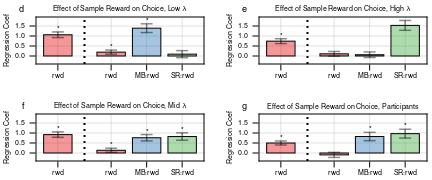

In [61]:
f = Figure(resolution=72 .* (6.0, 2.5))
colors = categorical_colors(:Set1, 4)

coefs_rwd = coefs_rwd_low
stderrs_rwd = stderrs_rwd_low
pvals_rwd = pvals_rwd_low
coefs_full = coefs_full_low
stderrs_full = stderrs_full_low
pvals_full = pvals_full_low
ax = Axis(f[1,1], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    title = "Effect of Sample Reward on Choice, Low λ",
)
Label(f[1, 1, TopLeft()], "d", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.4, 1.95)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*")
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*")
    end
end

coefs_rwd = coefs_rwd_high
stderrs_rwd = stderrs_rwd_high
pvals_rwd = pvals_rwd_high
coefs_full = coefs_full_high
stderrs_full = stderrs_full_high
pvals_full = pvals_full_high
ax = Axis(f[1,2], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    title = "Effect of Sample Reward on Choice, High λ",
)
Label(f[1, 2, TopLeft()], "e", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.4, 1.95)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*")
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*")
    end
end

coefs_rwd = coefs_rwd_mid
stderrs_rwd = stderrs_rwd_mid
pvals_rwd = pvals_rwd_mid
coefs_full = coefs_full_mid
stderrs_full = stderrs_full_mid
pvals_full = pvals_full_mid
ax = Axis(f[2,1], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    title = "Effect of Sample Reward on Choice, Mid λ",
)
Label(f[2, 1, TopLeft()], "f", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.4, 1.95)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*")
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*")
    end
end

coefs_rwd = coefs_rwd_participants
stderrs_rwd = stderrs_rwd_participants
pvals_rwd = pvals_rwd_participants
coefs_full = coefs_full_participants
stderrs_full = stderrs_full_participants
pvals_full = pvals_full_participants
ax = Axis(f[2,2], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    title = "Effect of Sample Reward on Choice, Participants",
)
Label(f[2, 2, TopLeft()], "g", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.4, 1.95)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*")
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*")
    end
end


save("figures/model_coeffs.pdf", f, pt_per_unit=1)
f